# TEST CASE:

coming from the example in https://keras.io/examples/audio/ctc_asr/ 


# This script works best with the following machine configurations:
    - 16+ gigs of ram
    - 4 GPUs or more
    - 16 cores
    
Training for one epoch under these conditions lasts around 15 min. Suggested training should take around 25 to 50 epochs to achieve ideal WER. Cloud based computing optimized for keras/tensorflow and python 3.6+ are best.

In [ ]:
# Define the number of epochs.
epochs = 30

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_io as tfio
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from IPython import display
from jiwer import wer
import re
import num2words
import os
# from moviepy.editor import AudioFileClip
from scipy.io import wavfile as wav




os.chdir('..')
from source.pipeline import pipeline
import IPython.display as ipd

In [3]:
# !pip install tensorflow==2.8.0
# !pip install keras==2.6.0

In [4]:
# !pip install numpy==1.16.0
# !pip install pandas 

### Import dataset

In [5]:
# Normalize Text to Train on 
def replace_num(text):
    text = re.sub(r"(\d+)", lambda x: num2words.num2words(int(x.group(0))).replace("-"," ")\
                  if len(str(int(x.group(0))))!=4 \
                  else num2words.num2words(int(x.group(0)),to='year').replace("-"," ") , text)
    return text



In [6]:
meta_df = pd.read_csv("data/electrolarynx_shorter_audio_cuts/metadata.csv",index_col='index')

meta_df.head()

# remove punctuation and capilalized letters.
meta_df['normalized_text'] = meta_df["true_text"].str.replace('[^\w\s]','').str.lower()

# normalize numbers in text
meta_df['normalized_text'] = meta_df['normalized_text'].apply(lambda x: replace_num(x))

# show first few rows
column_map = {'normalized_text':'normalized_transcription',
             'filename':'file_name'}
meta_df = meta_df.rename(columns=column_map)[['file_name','normalized_transcription']]
meta_df['file_name'] = meta_df['file_name'] + '.wav'
meta_df['file_name'] = "data/electrolarynx_shorter_audio_cuts/"+meta_df['file_name']

/tmp/ipykernel_45442/2875984278.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  meta_df['normalized_text'] = meta_df["true_text"].str.replace('[^\w\s]','').str.lower()


# Pre Processing

In [7]:
import wave
import librosa
import soundfile as sf

def check_chunks(files, CORRUPT_DIR):
    
    i = 0
    for filename in files:
        try:
            # get size of data chunk and add size of FMT header = 44
            with wave.open(filename, 'r') as fin:
                header_fsize = (fin.getnframes() * fin.getnchannels() * fin.getsampwidth()) + 44

                # get actual files
                file_fsize = os.path.getsize(filename)

                # compare both sizes
                if header_fsize != file_fsize:
                    print("Found a file with extra chunks: ", filename)
                    print(header_fsize, file_fsize)
                    i = i + 1

                    new_full_filename = os.path.splitext(filename)  ## just separate out wav from name
                    new_filename = new_full_filename[0] + "_processed" + ".wav"
                    audio_in, sr = librosa.load(filename, sr=24000)
                    sf.write(new_filename, audio_in, 16000, subtype='PCM_16')
                    print('File fixed and saved as: ', new_filename)

                    # try to fix file and save with suffix "processed" and move original file to another folder
                    try:
                        FIXED_CHUNK_DIR = os.path.join(CORRUPT_DIR, "fixed_chunks")
                        if not os.path.isdir(FIXED_CHUNK_DIR):
                            os.mkdir(FIXED_CHUNK_DIR)
                        shutil.move(filename, FIXED_CHUNK_DIR)
                        print('Moving original file to: ', FIXED_CHUNK_DIR)

                      # sometimes, the original file fails to move, but the processed file is successfully created
                    except:
                        print("Original file cannot be moved, please move manually")
                        continue

        # in case the file isn't fixed:
        except:
            # trying to at least move it out of the correct sound file folder 
            try:
                CORRUPT_CHUNK_DIR = os.path.join(CORRUPT_DIR, "corrupt_chunks")
                if not os.path.isdir(CORRUPT_CHUNK_DIR):
                    os.mkdir(CORRUPT_CHUNK_DIR)

                print("This file cannot be fixed:  ", filename, "\nMoving it to ", CORRUPT_CHUNK_DIR)
                shutil.move(filename, CORRUPT_CHUNK_DIR)
                # os.remove(filename)

            # if the unfixed file refuses to move
            except:
                print("This file cannot be fixed: ", filename, "\nPlease remove manually")
                continue
            continue
    print("done")
    return



In [8]:
# Clean out any corrupted files from IOS
# check_chunks(meta_df['file_name'], 'data')

In [9]:
metadata_df = meta_df.copy()
metadata_df['file_name'] = metadata_df['file_name'].str.replace('.wav','_processed.wav')

/tmp/ipykernel_45442/651740532.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  metadata_df['file_name'] = metadata_df['file_name'].str.replace('.wav','_processed.wav')


## Test Train Split

In [10]:
split = int(len(metadata_df) * 0.90)
df_train = metadata_df[:split]
df_val = metadata_df[split:]

print(f"Size of the training set: {len(df_train)}")
print(f"Size of the training set: {len(df_val)}")

Size of the training set: 429
Size of the training set: 48


In [11]:
# The set of characters accepted in the transcription.
characters = [x for x in "abcdefghijklmnopqrstuvwxyz'?! "]
# Mapping characters to integers
char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")
# Mapping integers back to original characters
num_to_char =keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', ' '] (size =31)


2023-04-14 19:31:34.207682: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-14 19:31:35.748009: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22305 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:25:00.0, compute capability: 8.6
2023-04-14 19:31:35.749704: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22289 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:41:00.0, compute capability: 8.6
2023-04-14 19:31:35.751096: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/

In [12]:
# An integer scalar Tensor. The window length in samples.
frame_length = 256
# An integer scalar Tensor. The number of samples to step.
frame_step = 160
# An integer scalar Tensor. The size of the FFT to apply.
# If not provided, uses the smallest power of 2 enclosing frame_length.
fft_length = 384

batch_size=32

# def encode_single_sample(wav_file, label):
#     ###########################################
#     ##  Process the Audio
#     ##########################################
#     # 1. Read wav file
#     print(wav_file)
#     def get_wav(in_tens):
#         samples,dat =  wav.read(in_tens.numpy())
#         out = np.reshape(dat,(dat.shape[0]*2,1))
#         return out
#     def get_len(in_tens):
#         _,dat =  wav.read(in_tens.numpy())
#         samples = tf.shape(dat).numpy()[0]
#         return samples*2
#     data = tf.py_function(get_wav, [wav_file], [tf.float32])
#     samples = tf.py_function(get_len, [wav_file],[tf.float32])
#     data = tf.cast(data,tf.float32)


    
    
# #     f = tf.py_function(find_wav, [file],Tout=tf.float32)
# #     audio = tf.convert_to_tensor(data)#data[:,[0]])

# #     audio = tf.squeeze(data, axis=-1,)
#     audio = tf.reshape(data, (samples,1))
# #     print(audio)
#     # 3. Change type to float
# #     audio = tf.cast(data, tf.float32)
    
#     # 4. Get the spectrogram
#     spectrogram = tf.signal.stft(
#         audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length
#     )
    
#     # 5. We only need the magnitude, which can be derived by applying tf.abs
#     spectrogram = tf.abs(spectrogram)
#     spectrogram = tf.math.pow(spectrogram, 0.5)
    
#     # 6. normalisation
#     means = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
#     stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
#     spectrogram = (spectrogram - means) / (stddevs + 1e-10)
#     ###########################################
#     ##  Process the label
#     ##########################################
#     # 7. Convert label to Lower case
#     label = tf.strings.lower(label)
#     # 8. Split the label
#     label = tf.strings.unicode_split(label, input_encoding="UTF-8")
#     # 9. Map the characters in label to numbers
#     label = char_to_num(label)
#     # 10. Return a dict as our model is expecting two inputs
#     return spectrogram, label


def encode_single_sample(wav_file, label):
    ###########################################
    ##  Process the Audio
    ##########################################
    # 1. Read wav file
    file = tf.io.read_file(wav_file)
    
    # 2. Decode the wav file
    audio, _ = tf.audio.decode_wav(file,desired_channels=1)
    print(audio.shape)
    audio = tf.squeeze(audio, axis=-1)
    # 3. Change type to float
    audio = tf.cast(audio, tf.float32)
    # 4. Get the spectrogram
    spectrogram = tf.signal.stft(
        audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length
    )
    # 5. We only need the magnitude, which can be derived by applying tf.abs
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.math.pow(spectrogram, 0.5)
    # 6. normalisation
    means = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
    stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
    spectrogram = (spectrogram - means) / (stddevs + 1e-10)
    ###########################################
    ##  Process the label
    ##########################################
    # 7. Convert label to Lower case
    label = tf.strings.lower(label)
    # 8. Split the label
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")
    # 9. Map the characters in label to numbers
    label = char_to_num(label)
    # 10. Return a dict as our model is expecting two inputs
    return spectrogram, label



### Create dataset objects


In [13]:

batch_size = 32
# Define the trainig dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_train["file_name"]), list(df_train["normalized_transcription"]))
)
train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Define the validation dataset
validation_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_val["file_name"]), list(df_val["normalized_transcription"]))
)
validation_dataset = (
    validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

(None, 1)
(None, 1)


In [14]:

def plot_spectrogram_example(dataset,df):
    fig = plt.figure(figsize=(8, 5))
    for batch in dataset.take(1):
        spectrogram = batch[0][0].numpy()
        spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
        label = batch[1][0]
        
        # Spectrogram
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        ax = plt.subplot(2, 1, 1)
        ax.imshow(spectrogram, vmax=1)
        ax.set_title(label)
        ax.axis("off")
        
        # Wav
        file = tf.io.read_file(df.iloc[0]["file_name"])
        audio, _ = tf.audio.decode_wav(file)
        audio = audio.numpy()
        ax = plt.subplot(2, 1, 2)
        plt.plot(audio)
        ax.set_title("Signal Wave")
        ax.set_xlim(0, len(audio))
        display.display(display.Audio(np.transpose(audio), rate=24000))
    plt.show()
    




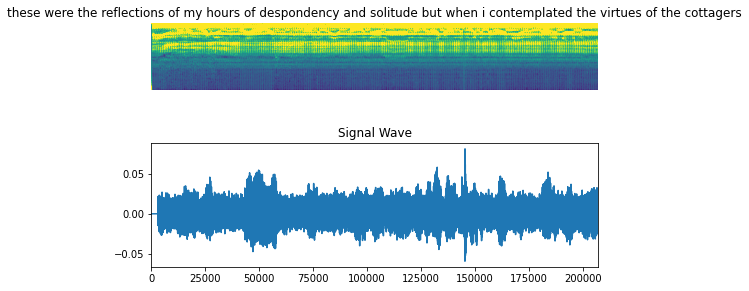

In [15]:
plot_spectrogram_example(train_dataset,df_train)

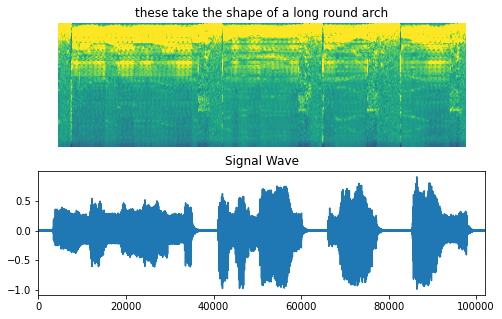

In [16]:
plot_spectrogram_example(validation_dataset,df_val)

### Modeling: Loss Function

In [17]:

def CTCLoss(y_true, y_pred):
    # Compute the training-time loss value
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

### Modeling: 2D CNN and RNN Layered Deep Learning

In [22]:
def build_model(input_dim, output_dim, rnn_layers=5, rnn_units=128):
    """Model similar to DeepSpeech2."""
    # Model's input
    input_spectrogram = layers.Input((None, input_dim), name="input")
    
    # Expand the dimension to use 2D CNN.
    x = layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectrogram)
    
    # Convolution layer 1
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 41],
        strides=[2, 2],
        padding="same",
        use_bias=False,
        name="conv_1",
    )(x)
    x = layers.BatchNormalization(name="conv_1_bn")(x)
    x = layers.ReLU(name="conv_1_relu")(x)
    
    # Convolution layer 2
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 21],
        strides=[1, 2],
        padding="same",
        use_bias=False,
        name="conv_2",
    )(x)
    x = layers.BatchNormalization(name="conv_2_bn")(x)
    x = layers.ReLU(name="conv_2_relu")(x)
    
    # Reshape the resulted volume to feed the RNNs layers
    x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)
    
    # RNN layers
    for i in range(1, rnn_layers + 1):
        recurrent = layers.GRU(
            units=rnn_units,
            activation="tanh",
            recurrent_activation="sigmoid",
            use_bias=True,
            return_sequences=True,
            reset_after=True,
            name=f"gru_{i}",
        )
        x = layers.Bidirectional(
            recurrent, name=f"bidirectional_{i}", merge_mode="concat"
        )(x)
        if i < rnn_layers:
            x = layers.Dropout(rate=0.5)(x)
    
    # Dense layer
    x = layers.Dense(units=rnn_units * 2, name="dense_1")(x)
    x = layers.ReLU(name="dense_1_relu")(x)
    x = layers.Dropout(rate=0.5)(x)
    
    # Classification layer
    output = layers.Dense(units=output_dim + 1, activation="softmax")(x)
    
    # Model
    model = keras.Model(input_spectrogram, output, name="DeepSpeech_2")
    
    # Optimizer
    opt = keras.optimizers.Adam(learning_rate=1e-7)
    
    # Compile the model and return
    model.compile(optimizer=opt, loss=CTCLoss)
    return model


# Get the model
model = build_model(
    input_dim=fft_length // 2 + 1,
    output_dim=char_to_num.vocabulary_size(),
    rnn_units=512,
)
model.summary(line_length=110)

Model: "DeepSpeech_2"
______________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                                Param #          
 input (InputLayer)                              [(None, None, 193)]                         0                
                                                                                                              
 expand_dim (Reshape)                            (None, None, 193, 1)                        0                
                                                                                                              
 conv_1 (Conv2D)                                 (None, None, 97, 32)                        14432            
                                                                                                              
 conv_1_bn (BatchNormalization)                  (None, None, 97, 32)                     

### Training Prep


In [23]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    
    # Iterate over the results and get back the text
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text


# A callback class to output a few transcriptions during training
class CallbackEval(keras.callbacks.Callback):
    """Displays a batch of outputs after every epoch."""

    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset

    def on_epoch_end(self, epoch: int, logs=None):
        predictions = []
        targets = []
        for batch in self.dataset:
            X, y = batch
            batch_predictions = model.predict(X)
            batch_predictions = decode_batch_predictions(batch_predictions)
            predictions.extend(batch_predictions)
            for label in y:
                label = (
                    tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
                )
                targets.append(label)
        wer_score = wer(targets, predictions)
        print("-" * 100)
        print(f"Word Error Rate: {wer_score:.4f}")
        print("-" * 100)
        for i in np.random.randint(0, len(predictions), 2):
            print(f"Target    : {targets[i]}")
            print(f"Prediction: {predictions[i]}")
            print("-" * 100)

### Modeling: Training

In [ ]:


# Callback function to check transcription on the val set.
validation_callback = CallbackEval(validation_dataset)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[validation_callback],
)

Epoch 1/30


2023-04-14 19:48:54.834704: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101
2023-04-14 19:49:02.560779: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


14/14 [==============================] - ETA: 0s - loss: 2649.1917----------------------------------------------------------------------------------------------------
Word Error Rate: 1.0761
----------------------------------------------------------------------------------------------------
Target    : when a man looks for something beyond his reach his friends say
Prediction: dx x b d v d x  x  d d dxb d ixdd d d dxb bi d bd p
----------------------------------------------------------------------------------------------------
Target    : with its path high above and its two ends apparently beyond the horizon
Prediction:  pdpxpbp bpx p pb pxpxdpbpb'dp d pbpx p  bd p
----------------------------------------------------------------------------------------------------
14/14 [==============================] - 69s 3s/step - loss: 2649.1917 - val_loss: 1868.1964
Epoch 2/30
14/14 [==============================] - ETA: 0s - loss: 2639.1780------------------------------------------------------

In [ ]:
# Plot CTC Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Inference

In [24]:
# Let's check results on more validation samples
predictions = []
targets = []
for batch in validation_dataset:
    X, y = batch
    batch_predictions = model.predict(X)
    batch_predictions = decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions)
    for label in y:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        targets.append(label)
wer_score = wer(targets, predictions)
print("-" * 100)
print(f"Word Error Rate: {wer_score:.4f}")
print("-" * 100)
for i in np.random.randint(0, len(predictions), 5):
    print(f"Target    : {targets[i]}")
    print(f"Prediction: {predictions[i]}")
    print("-" * 100)

----------------------------------------------------------------------------------------------------
Word Error Rate: 1.0000
----------------------------------------------------------------------------------------------------
Target    : there is according to legend a boiling pot of gold at one end people look but no one ever finds it
Prediction: e
----------------------------------------------------------------------------------------------------
Target    : when the sunlight strikes raindrops in the air they act like a prism
Prediction: e
----------------------------------------------------------------------------------------------------
Target    : when a man looks for something beyond his reach his friends say
Prediction: e
----------------------------------------------------------------------------------------------------
Target    : there is according to legend a boiling pot of gold at one end people look but no one ever finds it
Prediction: e
------------------------------------

In [ ]:
# save CTC Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('loss_performance_electrolarynx.png')

In [ ]:
# save WER score
predictions = []
targets = []
for batch in validation_dataset:
    X, y = batch
    batch_predictions = model.predict(X)
    batch_predictions = decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions)
    for label in y:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        targets.append(label)
wer_score = wer(targets, predictions)
pd.DataFrame([wer_score],columns='wer_score').to_csv("wer_score_30_epochs.csv")

In [ ]:
# Save Model training checkpoint
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)